# Etapa 1

In [1]:
import numpy as np
import torch 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

import cv2
import numpy as np
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile

dim = 100
print(os.listdir("fruits-360_dataset_100x100"))




['fruits-360']


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Modelul rulează pe {device}")

Modelul rulează pe cuda


In [3]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "fruits-360_dataset_100x100/fruits-360/"+ data_type + "/"

        for i, f in enumerate(fruits):
            p = f"{path}{f}"
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "fruits-360_dataset_100x100/fruits-360/" + v + "/"

            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("./fruits-360_dataset_100x100/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

In [4]:
fruits = getAllFruits()
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)



There are  473   TRAINING  images of  APPLE 6
There are  492   TRAINING  images of  APPLE BRAEBURN 1
There are  444   TRAINING  images of  APPLE CRIMSON SNOW 1
There are  480   TRAINING  images of  APPLE GOLDEN 1
There are  492   TRAINING  images of  APPLE GOLDEN 2
There are  481   TRAINING  images of  APPLE GOLDEN 3
There are  492   TRAINING  images of  APPLE GRANNY SMITH 1
There are  456   TRAINING  images of  APPLE PINK LADY 1
There are  492   TRAINING  images of  APPLE RED 1
There are  492   TRAINING  images of  APPLE RED 2
There are  429   TRAINING  images of  APPLE RED 3
There are  490   TRAINING  images of  APPLE RED DELICIOUS 1
There are  492   TRAINING  images of  APPLE RED YELLOW 1
There are  672   TRAINING  images of  APPLE RED YELLOW 2
There are  702   TRAINING  images of  APPLE HIT 1
There are  492   TRAINING  images of  APRICOT 1
There are  427   TRAINING  images of  AVOCADO 1
There are  491   TRAINING  images of  AVOCADO RIPE 1
There are  490   TRAINING  images of  BANAN

## Extragere atribute

In [5]:
def preprocess_images(images, target_size=(32, 32)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
        
    return np.array(resized_images)

def extract_features_orb(images, max_keypoints=300, edge_threshold=6):
    orb = cv2.ORB_create(nfeatures=max_keypoints, edgeThreshold=edge_threshold, patchSize=4)
    descriptors_list = []

    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = orb.detectAndCompute(gray_img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.zeros((0, 32)))
    
    return descriptors_list

def reduce_dimensionality(features, n_components=20):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=n_components, random_state=42)
    reduced_features = pca.fit_transform(scaled_features)
    
    return reduced_features, scaler, pca

def generate_histograms(descriptors_list, kmeans, pca=None):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            if pca is not None:
                descriptors = pca.transform(descriptors)  
            cluster_assignments = kmeans.predict(descriptors)  
            histogram, _ = np.histogram(cluster_assignments, bins=np.arange(kmeans.n_clusters + 1))
        else:
            histogram = np.zeros(kmeans.n_clusters)
        histograms.append(histogram)
        
    return np.vstack(histograms)

def feature_selection(features, method='variance', percentile=10):
    if method == 'variance':
        selector = VarianceThreshold(threshold=0.01) 
    elif method == 'percentile':
        selector = SelectPercentile(percentile=percentile)
    else:
        raise ValueError("Metoda de selecție trebuie să fie 'variance' sau 'percentile'.")
    
    selected_features = selector.fit_transform(features)
    
    return selected_features, selector

def bag_of_words(descriptors, k, random_state=42):
    all_descriptors = np.vstack([desc for desc in descriptors if desc.shape[0] > 0])
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(all_descriptors)
    
    return kmeans


# Redimensionăm imaginile
X_t_resized = preprocess_images(X_t, target_size=(32, 32))
X_test_resized = preprocess_images(X_test, target_size=(32, 32))

# Extragem descriptorii ORB
train_descriptors = extract_features_orb(X_t_resized)
test_descriptors = extract_features_orb(X_test_resized)

# Aplicăm KMeans pe descriptorii ORB
n_clusters = 100
kmeans = bag_of_words(train_descriptors, k=n_clusters)

# Generăm histogramele pe baza cluster-urilor KMeans
X_train_histograms = generate_histograms(train_descriptors, kmeans, pca=None)
X_test_histograms = generate_histograms(test_descriptors, kmeans, pca=None)

# Standardizarea și reducerea dimensionalității
X_train_scaled, scaler, pca = reduce_dimensionality(X_train_histograms, n_components=20)
X_test_scaled = pca.transform(scaler.transform(X_test_histograms))

# Selecția atributelor
X_train_selected, selector = feature_selection(X_train_scaled, method='variance', percentile=10)
X_test_selected = selector.transform(X_test_scaled)

# Afișăm dimensiunile seturilor finale
print(f"Dimensiunea setului de antrenament: {X_train_selected.shape}")
print(f"Dimensiunea setului de test: {X_test_selected.shape}")


Dimensiunea setului de antrenament: (70491, 20)
Dimensiunea setului de test: (23619, 20)


## Visualizarea distributei claselor

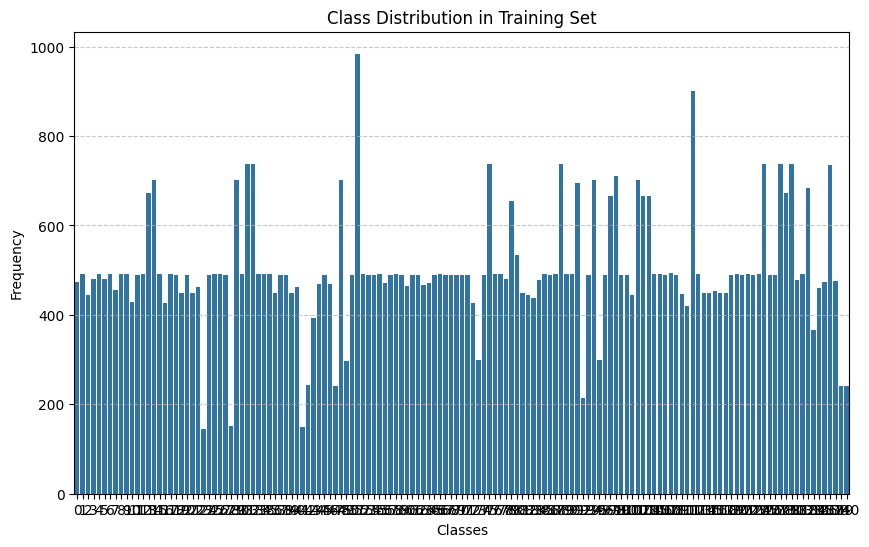

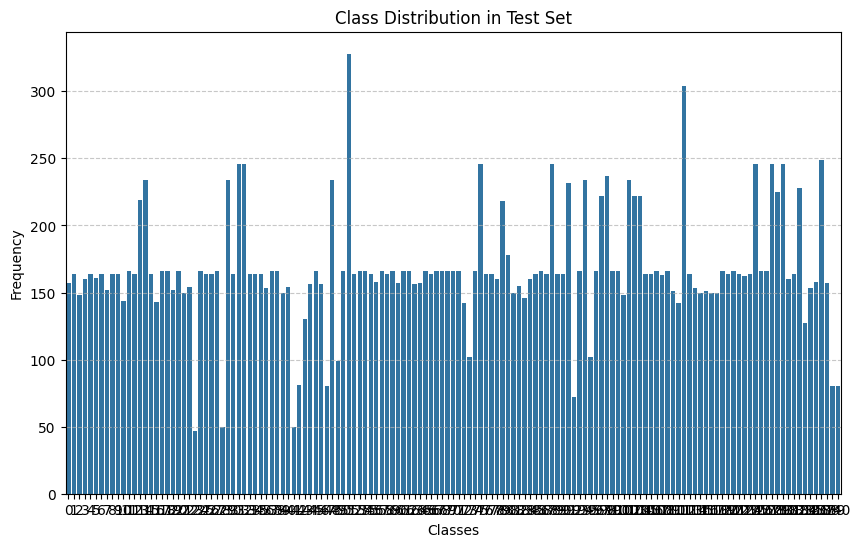

In [6]:
def plot_class_distribution(labels, title):
    label_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_class_distribution(y_train, "Class Distribution in Training Set")
plot_class_distribution(y_test, "Class Distribution in Test Set")


###  Varianta cumulativa explicata de componentele principale (PCA).

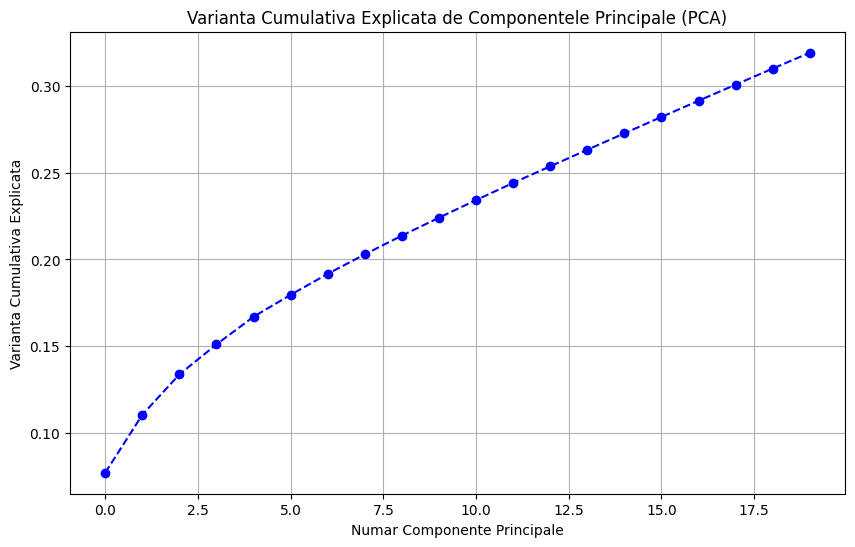

In [7]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Varianta Cumulativa Explicata de Componentele Principale (PCA)')
plt.xlabel('Numar Componente Principale')
plt.ylabel('Varianta Cumulativa Explicata')
plt.grid(True)
plt.show()


### Cantitatea de variabilitate explicata de PCA

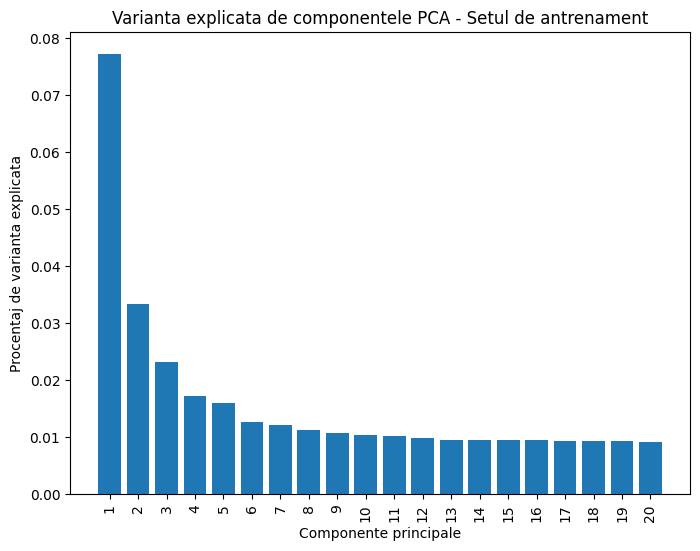

In [8]:
def plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA"):
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=range(1, len(explained_variance) + 1))
    plt.xlabel('Componente principale')
    plt.ylabel('Procentaj de varianta explicata')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA - Setul de antrenament")


### Vizualizarea punctelor cheie identificate în imagini prin suprapunerea lor peste imaginea originală

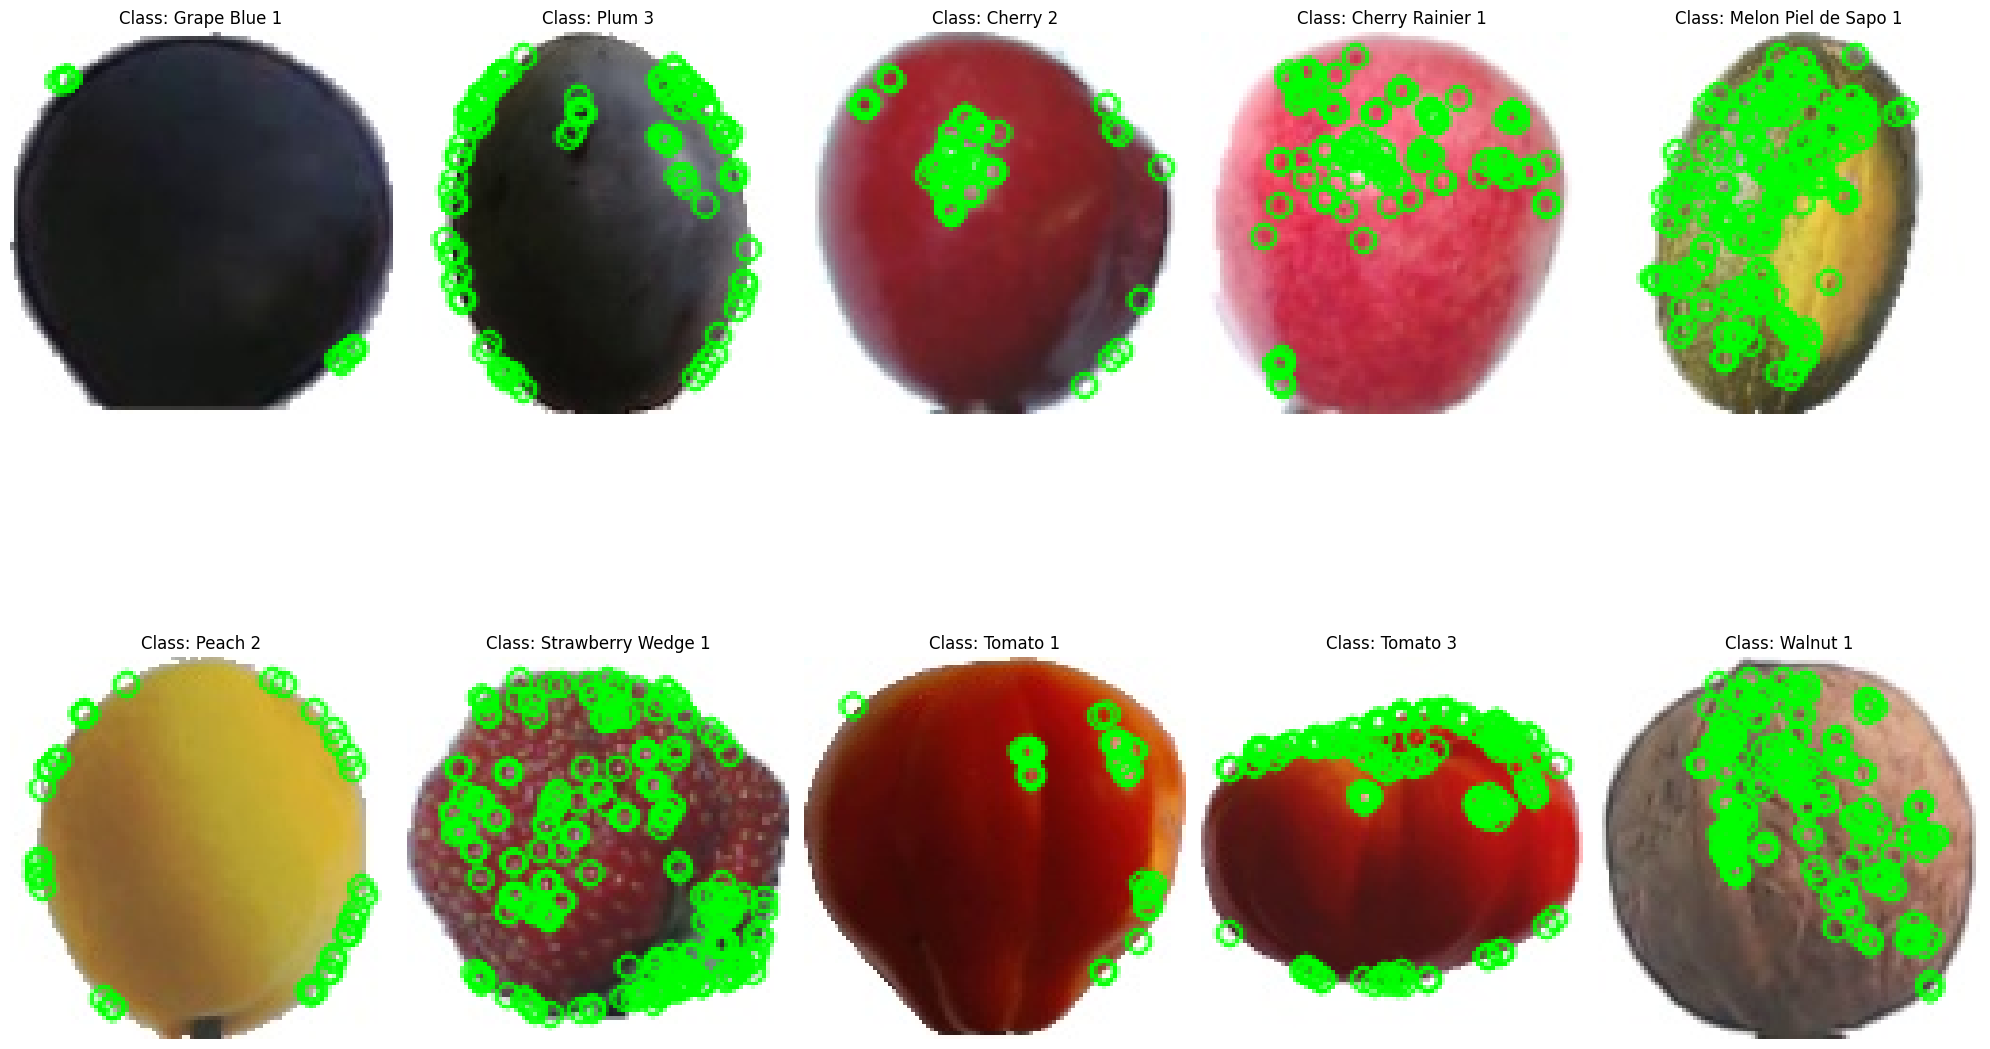

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)
class_frequencies = dict(zip(unique, counts))

sorted_classes = sorted(class_frequencies.items(), key=lambda x: x[1], reverse=True)

top_10_classes = [class_ for class_, _ in sorted_classes[:10]]


def display_orb_keypoints(images, labels, class_names, n=1):
    orb = cv2.ORB_create(nfeatures=300, scaleFactor=1.2, edgeThreshold=6, patchSize=4)
    
    plt.figure(figsize=(20, 15))
    for i in range(n):
        kp, _ = orb.detectAndCompute(images[i], None)
    
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        image_with_keypoints = cv2.drawKeypoints(image_rgb, kp, None, color=(0, 255, 0))
        image_with_keypoints = cv2.cvtColor(image_with_keypoints, cv2.COLOR_RGB2BGR)
        
        plt.subplot(2, 5, i+1)  
        plt.imshow(image_with_keypoints)
        
       
        class_label = labels[i]
        class_name = class_names[class_label]  
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def select_one_image_from_each_class(images, labels, top_classes):
    selected_images = []
    selected_labels = []
    
    for class_id in top_classes:
        class_indices = np.where(labels == class_id)[0]
        if len(class_indices) > 0:
            selected_images.append(images[class_indices[0]])  
            selected_labels.append(class_id)  
    
    return selected_images, selected_labels

selected_images, selected_labels = select_one_image_from_each_class(X_t, y_train, top_10_classes)
class_names = getAllFruits()
display_orb_keypoints(selected_images, selected_labels, class_names, n=len(selected_images))




# Etapa 2

## Functions for Data Visualization 


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
# evaluate model on test set
def evaluate_model(model, test_data, test_labels):
    test_loss, test_accuracy = model.evaluate(test_data, test_labels)
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
    return test_loss, test_accuracy

# calculate per-class accuracy
def calculate_per_class_accuracy(y_test, y_pred, num_classes):
    accuracy_per_class = []
    for class_idx in range(num_classes):
        class_mask = (y_test == class_idx)
        class_accuracy = np.sum(y_pred[class_mask] == y_test[class_mask]) / np.sum(class_mask)
        accuracy_per_class.append(class_accuracy)
        print(f"Accuracy for class {class_idx}: {class_accuracy:.4f}")
    return accuracy_per_class

# gen classification report and save to CSV
def generate_classification_report_csv(y_test, y_pred, num_classes, filename='classification_report.csv'):
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    accuracy_per_class = calculate_per_class_accuracy(y_test, y_pred, num_classes)

    report_data = {
        'Class': list(range(num_classes)),
        'Precision': [report[str(i)]['precision'] for i in range(num_classes)],
        'Recall': [report[str(i)]['recall'] for i in range(num_classes)],
        'F1 Score': [report[str(i)]['f1-score'] for i in range(num_classes)],
        'Accuracy': accuracy_per_class  # per-class accuracy
    }
    # save to CSV
    df_report = pd.DataFrame(report_data)
    df_report.to_csv(filename, index=False)
    print(f"Classification report saved to {filename}")
    return report

# calculate Macro and Weighted avg
def calculate_macro_weighted_averages(report, accuracy_per_class, y_test, num_classes):
    # macro avg
    macro_avg_precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    macro_avg_recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    macro_avg_f1 = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])
    macro_avg_accuracy = np.mean(accuracy_per_class)

    # weighted avg
    support_per_class = [np.sum(y_test == i) for i in range(num_classes)]  # support for each class
    weighted_avg_precision = np.sum([report[str(i)]['precision'] * support_per_class[i] for i in range(num_classes)]) / np.sum(support_per_class)
    weighted_avg_recall = np.sum([report[str(i)]['recall'] * support_per_class[i] for i in range(num_classes)]) / np.sum(support_per_class)
    weighted_avg_f1 = np.sum([report[str(i)]['f1-score'] * support_per_class[i] for i in range(num_classes)]) / np.sum(support_per_class)
    weighted_avg_accuracy = np.sum(np.array(accuracy_per_class) * np.array(support_per_class)) / np.sum(support_per_class)

    # print acro and weighted avg
    print(f"\nMacro Average Precision: {macro_avg_precision:.4f}")
    print(f"Macro Average Recall: {macro_avg_recall:.4f}")
    print(f"Macro Average F1-Score: {macro_avg_f1:.4f}")
    print(f"Macro Average Accuracy: {macro_avg_accuracy:.4f}")

    print(f"\nWeighted Average Precision: {weighted_avg_precision:.4f}")
    print(f"Weighted Average Recall: {weighted_avg_recall:.4f}")
    print(f"Weighted Average F1-Score: {weighted_avg_f1:.4f}")
    print(f"Weighted Average Accuracy: {weighted_avg_accuracy:.4f}")
    
    return macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy



## MLP pe atributele extrase în etapa 1

In [40]:
import os
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

physical_devices = tf.config.list_physical_devices('GPU')

# check if GPU is available
if not physical_devices:
    print("No GPU found. Exiting script.")
    exit()  
else:
    print(f"GPU Available: {physical_devices}")
    
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        
# number of classes
num_classes = len(np.unique(y_train))

def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))  # input layer
    model.add(Dropout(0.5))  # dropout for reg
    model.add(Dense(64, activation='relu'))  # hidden layer
    model.add(Dense(num_classes, activation='softmax'))  # output layer
    
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# feature selection using Random Forest
def feature_selection_with_rf(features, labels, max_features=128):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(features, labels)
    
    # aelect the most important features
    selector = SelectFromModel(rf, max_features=max_features, importance_getter="auto")
    selected_features = selector.transform(features)
    
    return selected_features, selector

# PCA
X_train_scaled, scaler, pca = reduce_dimensionality(X_train_histograms, n_components=100)
X_test_scaled = pca.transform(scaler.transform(X_test_histograms))

# feature selection for train and test sets
train_selected, selector = feature_selection_with_rf(X_train_scaled,  y_train, max_features=128)
test_selected = selector.transform(X_test_scaled)


model = create_mlp_model(train_selected.shape[1])

# measure training time
start_time = time.time()

# train the model
history_fruits_feature = model.fit(
    train_selected, y_train, 
    epochs=20, batch_size=32, 
    validation_data=(test_selected, y_test)
    )

end_time = time.time()
training_time = end_time - start_time


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.0854 - loss: 4.0656 - val_accuracy: 0.1380 - val_loss: 3.5709
Epoch 2/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1626 - loss: 3.3681 - val_accuracy: 0.1587 - val_loss: 3.4871
Epoch 3/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1766 - loss: 3.2737 - val_accuracy: 0.1652 - val_loss: 3.4739
Epoch 4/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1851 - loss: 3.2016 - val_accuracy: 0.1761 - val_loss: 3.4274
Epoch 5/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1922 - loss: 3.1673 - val_accuracy: 0.1791 - val_loss: 3.4127
Epoch 6/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1981 - loss: 3.1320 - val_accuracy: 0.1855 - val_loss: 3.4120
Epoch 7/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2002 - loss: 3.1206 - val_accuracy: 0.1834 - val_loss: 3.4127
Epoch 8/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2027 - loss: 3.1051 

739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1591 - loss: 3.5211
Test loss: 3.4118635654449463, Test accuracy: 0.1880689263343811
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy for class 0: 0.2803
Accuracy for class 1: 0.0000
Accuracy for class 2: 0.0203
Accuracy for class 3: 0.0750
Accuracy for class 4: 0.0183
Accuracy for class 5: 0.0621
Accuracy for class 6: 0.0549
Accuracy for class 7: 0.0197
Accuracy for class 8: 0.1159
Accuracy for class 9: 0.0671
Accuracy for class 10: 0.1250
Accuracy for class 11: 0.0000
Accuracy for class 12: 0.0244
Accuracy for class 13: 0.0046
Accuracy for class 14: 0.1325
Accuracy for class 15: 0.0000
Accuracy for class 16: 0.0420
Accuracy for class 17: 0.2349
Accuracy for class 18: 0.1145
Accuracy for class 19: 0.2434
Accuracy for class 20: 0.1084
Accuracy for class 21: 0.2200
Accuracy for class 22: 0.0000
Accuracy for class 23: 0.0000
Accuracy for class 24: 0.2470
Accuracy for class 25: 0.0671
Accuracy for class 26: 0.1280
Accuracy for class 

/home/regelepirat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/regelepirat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/regelepirat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


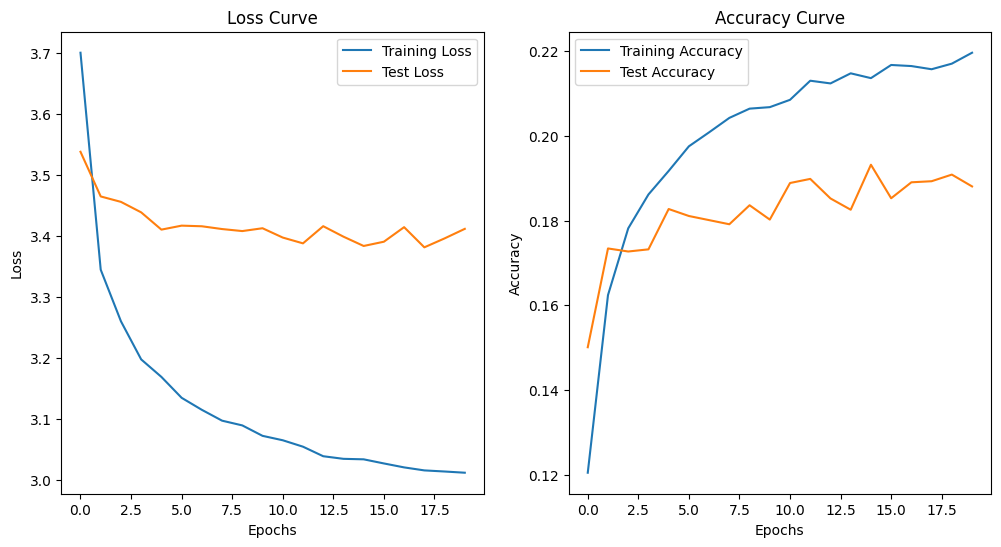


Training time: 174.35 seconds


In [12]:
# DATA VISUALIZATION

test_loss, test_accuracy = evaluate_model(model, test_selected, y_test)

y_pred = np.argmax(model.predict(test_selected), axis=1)

accuracy_per_class = calculate_per_class_accuracy(y_test, y_pred, num_classes)

report = generate_classification_report_csv(y_test, y_pred, num_classes, filename='fruit_classification_report_feature.csv')

macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy = calculate_macro_weighted_averages(report, accuracy_per_class, y_test, num_classes)


plot_training_history(history_fruits_feature)

print(f"\nTraining time: {training_time:.2f} seconds")


## Arhitectura de tip MLP direct peste imagini

In [38]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import time

def create_mlp_model(input_dim, num_classes):
    model = Sequential()
    
    model.add(Dense(512, activation='relu', input_dim=input_dim))  
    model.add(Dense(256, activation='relu')) 
    
    model.add(Dense(128, activation='relu')) 
    
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def flatten_images(images):
    return images.reshape(images.shape[0], -1) 
def normalize_images(images):
    return images / 255.0  

train_flattened = flatten_images(X_t_resized)  
test_flattened = flatten_images(X_test_resized) 

train_normalized = normalize_images(train_flattened)  
test_normalized = normalize_images(test_flattened)  

num_classes = len(np.unique(y_train))

model = create_mlp_model(train_normalized.shape[1], num_classes)



# measure training time
start_time = time.time()

# train the model
history_fruits_original = model.fit(
    train_normalized, y_train, 
    epochs=20, batch_size=32,  
    validation_data=(test_normalized, y_test), 
)

end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time} seconds")







Epoch 1/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4172 - loss: 2.3609 - val_accuracy: 0.7818 - val_loss: 0.8138
Epoch 2/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9005 - loss: 0.2943 - val_accuracy: 0.8570 - val_loss: 0.5628
Epoch 3/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9372 - loss: 0.1828 - val_accuracy: 0.8267 - val_loss: 0.7506
Epoch 4/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9533 - loss: 0.1425 - val_accuracy: 0.8640 - val_loss: 0.5997
Epoch 5/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9650 - loss: 0.1117 - val_accuracy: 0.8289 - val_loss: 0.8995
Epoch 6/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9665 - loss: 0.1032 - val_accuracy: 0.8909 - val_loss: 0.6370
Epoch 7/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9707 - loss: 0.0906 - val_accuracy: 0.9359 - val_loss: 0.3877
Epoch 8/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9769 - loss: 0.0

739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.8798
Test loss: 0.7153497338294983, Test accuracy: 0.9258224368095398
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy for class 0: 1.0000
Accuracy for class 1: 0.6646
Accuracy for class 2: 0.7432
Accuracy for class 3: 0.6875
Accuracy for class 4: 1.0000
Accuracy for class 5: 1.0000
Accuracy for class 6: 0.8841
Accuracy for class 7: 0.8947
Accuracy for class 8: 0.8780
Accuracy for class 9: 0.8354
Accuracy for class 10: 0.5347
Accuracy for class 11: 1.0000
Accuracy for class 12: 0.6280
Accuracy for class 13: 1.0000
Accuracy for class 14: 1.0000
Accuracy for class 15: 1.0000
Accuracy for class 16: 1.0000
Accuracy for class 17: 1.0000
Accuracy for class 18: 0.7289
Accuracy for class 19: 0.9013
Accuracy for class 20: 0.8253
Accuracy for class 21: 0.8600
Accuracy for class 22: 0.7338
Accuracy for class 23: 1.0000
Accuracy for class 24: 1.0000
Accuracy for class 25: 1.0000
Accuracy for class 26: 0.9939
Accuracy for class 

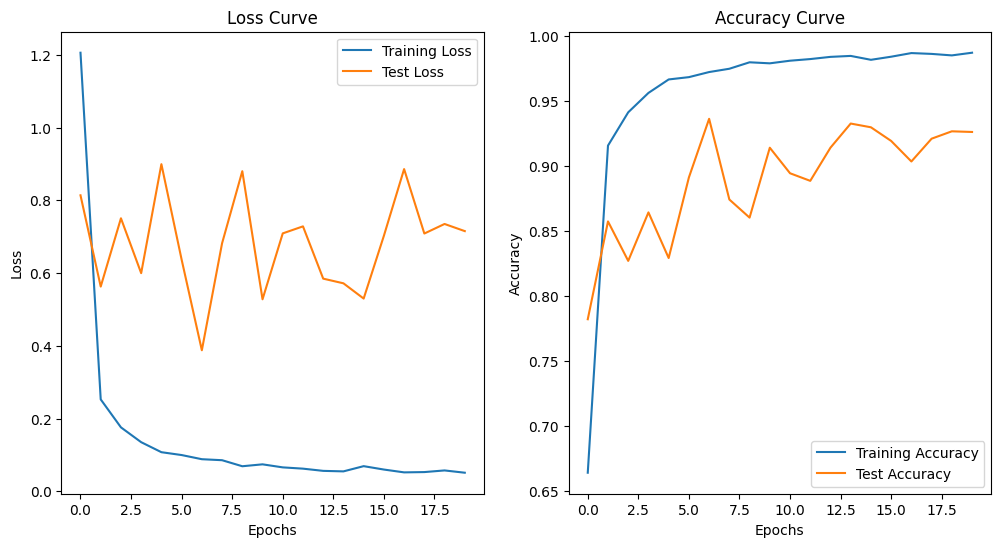


Training time: 220.95 seconds


In [39]:
# DATA VISUALIZATION

test_loss, test_accuracy = evaluate_model(model, test_normalized, y_test)

y_pred = np.argmax(model.predict(test_normalized), axis=1)

accuracy_per_class = calculate_per_class_accuracy(y_test, y_pred, num_classes)

report = generate_classification_report_csv(y_test, y_pred, num_classes, filename='fruit_classification_report_original.csv')

macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy = calculate_macro_weighted_averages(report, accuracy_per_class, y_test, num_classes)


plot_training_history(history_fruits_original)

print(f"\nTraining time: {training_time:.2f} seconds")


## Arhitectura de tip convoluțional

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def flatten_images(images):
    return images.reshape(images.shape[0], -1)  

def normalize_images(images):
    return images / 255.0



def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # first convolutional layer (32 filters)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # second convolutional layer (64 filters)
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # third convolutional layer (128 filters)
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # global average pooling
    model.add(GlobalAveragePooling2D())
    
    # fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7))  # dropout reg
    model.add(Dense(num_classes, activation='softmax'))  # output layer with num_classes
    
    # model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# prepare data augmentation 
datagen = ImageDataGenerator(
    rotation_range=30,  # random rotation
    width_shift_range=0.2,  # random horizontal shift
    height_shift_range=0.2,  # random vertical shift
    shear_range=0.2,  # shear transformation
    zoom_range=0.2,  # random zoom
    horizontal_flip=True,  # random horizontal flip
    fill_mode='nearest'  # fill empty pixels 
)

train_resized_normalized = normalize_images(X_t_resized)
test_resized_normalized = normalize_images(X_test_resized)


input_shape = train_resized_normalized.shape[1:] 

model_no_augmentation = create_cnn_model(input_shape, num_classes)

# measure training time
start_time_no_aug = time.time()

# train the model without augmentation
history_no_augmentation = model_no_augmentation.fit(
    train_resized_normalized, y_train, 
    epochs=20, batch_size=32, 
    validation_data=(test_resized_normalized, y_test)
)

end_time_no_aug = time.time()
training_time_no_aug = end_time_no_aug - start_time_no_aug

# measure training time
start_time_aug = time.time()

# create the CNN model with data augmentation
model_with_augmentation = create_cnn_model(input_shape, num_classes)

# train the model with augmentation
history_with_augmentation = model_with_augmentation.fit(
    datagen.flow(train_resized_normalized, y_train, batch_size=32), 
    epochs=20, 
    validation_data=(test_resized_normalized, y_test)
)

end_time_aug = time.time()
training_time_aug = end_time_aug - start_time_aug






/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


2025-01-12 22:16:13.612202: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-12 22:16:13.734822: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,13,13]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,15,15]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

2196/2203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3992 - loss: 2.4402

2025-01-12 22:16:27.193003: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[27,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-12 22:16:27.262550: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[27,64,13,13]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,32,15,15]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

2203/2203 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3998 - loss: 2.4369

2025-01-12 22:16:31.447515: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-12 22:16:31.519128: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,13,13]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,15,15]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

2203/2203 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.3999 - loss: 2.4364 - val_accuracy: 0.9139 - val_loss: 0.2997
Epoch 2/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8532 - loss: 0.4442 - val_accuracy: 0.8975 - val_loss: 0.3235
Epoch 3/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9016 - loss: 0.2943 - val_accuracy: 0.9494 - val_loss: 0.1820
Epoch 4/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9251 - loss: 0.2222 - val_accuracy: 0.9746 - val_loss: 0.1338
Epoch 5/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9360 - loss: 0.1937 - val_accuracy: 0.9449 - val_loss: 0.2182
Epoch 6/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9455 - loss: 0.1607 - val_accuracy: 0.9588 - val_loss: 0.1600
Epoch 7/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9488 - loss: 0.1526 - val_accuracy: 0.9792 - val_loss: 0.1250
Epoch 8/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9537 - loss: 0.1413 - val

/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2203/2203 ━━━━━━━━━━━━━━━━━━━━ 69s 27ms/step - accuracy: 0.2364 - loss: 3.1326 - val_accuracy: 0.7760 - val_loss: 0.7223
Epoch 2/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6420 - loss: 1.1171 - val_accuracy: 0.8207 - val_loss: 0.6541
Epoch 3/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.7334 - loss: 0.8130 - val_accuracy: 0.9207 - val_loss: 0.3268
Epoch 4/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.7853 - loss: 0.6562 - val_accuracy: 0.8893 - val_loss: 0.4449
Epoch 5/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.8109 - loss: 0.5794 - val_accuracy: 0.9205 - val_loss: 0.3592
Epoch 6/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.8299 - loss: 0.5123 - val_accuracy: 0.9264 - val_loss: 0.2749
Epoch 7/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.8445 - loss: 0.4775 - val_accuracy: 0.9401 - val_loss: 0.3219
Epoch 8/20
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.8524 - loss: 0.45

739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9770 - loss: 0.1199
Test loss: 0.12525272369384766, Test accuracy: 0.9770523905754089
739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8938 - loss: 0.6544
Test loss: 0.5837337374687195, Test accuracy: 0.8992336392402649
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

No augmentation
Accuracy for class 0: 1.0000
Accuracy for class 1: 0.9207
Accuracy for class 2: 1.0000
Accuracy for class 3: 1.0000
Accuracy for class 4: 1.0000
Accuracy for class 5: 0.9627
Accuracy for class 6: 0.9390
Accuracy for class 7: 1.0000
Accuracy for class 8: 1.0000
Accuracy for class 9: 0.9939
Accuracy for class 10: 1.0000
Accuracy for class 11: 1.0000
Accuracy for class 12: 0.9268
Accuracy for class 13: 1.0000
Accuracy for class 14: 1.0000
Accuracy for class 15: 1.0000
Accuracy for class 16: 1.0000
Accuracy for class 17: 1.0000
Accuracy for class 18: 1.0000
Accuracy for class 19: 0.9934
Accuracy for class 20: 0.9699


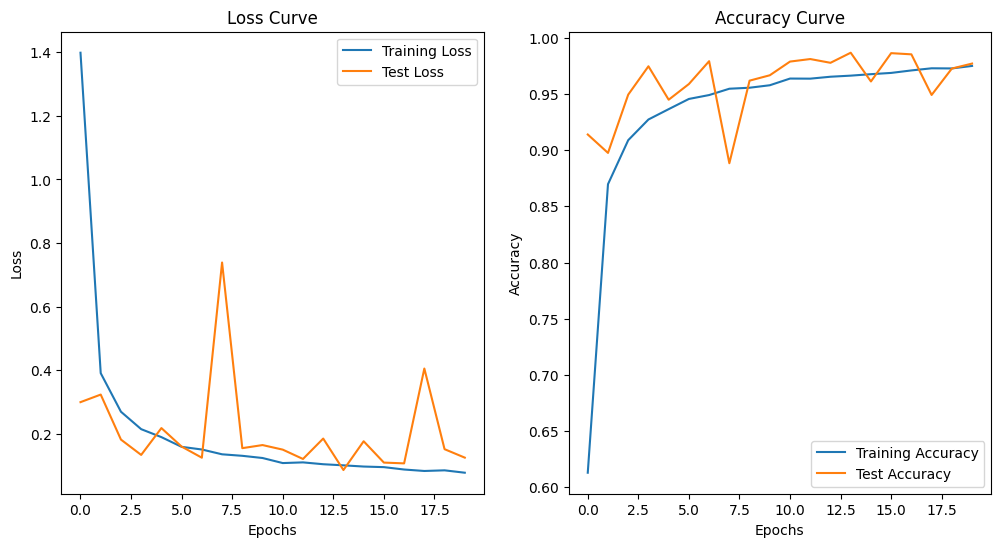


Augmentation


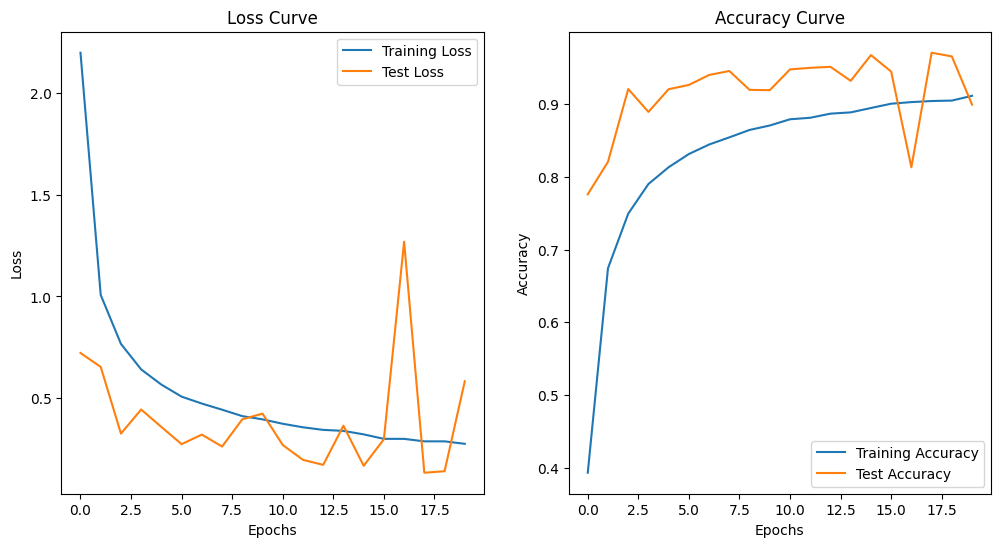


Training time no augmentation: 296.92 seconds

Training time augmentation: 1096.21 seconds


In [26]:
# DATA VISUALIZATION

test_loss_no_augmentation, test_accuracy_no_augmentation = evaluate_model(model_no_augmentation, test_resized_normalized, y_test)
test_loss_with_augmentation, test_accuracy_with_augmentation = evaluate_model(model_with_augmentation, test_resized_normalized, y_test)

y_pred_no_augmentation = np.argmax(model_no_augmentation.predict(test_resized_normalized), axis=1)
y_pred_with_augmentation = np.argmax(model_with_augmentation.predict(test_resized_normalized), axis=1)

print(f"\nNo augmentation")
accuracy_per_class_no_augmentation = calculate_per_class_accuracy(y_test, y_pred_no_augmentation, num_classes)

print(f"\nAugmentation")
accuracy_per_class_with_augmentation = calculate_per_class_accuracy(y_test, y_pred_with_augmentation, num_classes)

print(f"\nNo augmentation")
report_no_augmentation = generate_classification_report_csv(y_test, y_pred_no_augmentation, num_classes, filename='fruit_classification_report_no_augmentation.csv')

print(f"\nAugmentation")
report_with_augmentation = generate_classification_report_csv(y_test, y_pred_with_augmentation, num_classes, filename='fruit_classification_report_augmentation.csv')

print(f"\nNo augmentation")
macro_avg_no_augmentation, macro_avg_recall_no_augmentation, macro_avg_f1_no_augmentation, macro_avg_accuracy_no_augmentation, weighted_avg_precision_no_augmentation, weighted_avg_recall_no_augmentation, weighted_avg_f1_no_augmentation, weighted_avg_accuracy_no_augmentation = calculate_macro_weighted_averages(report_no_augmentation, accuracy_per_class_no_augmentation, y_test, num_classes)

print(f"\nAugmentation")
macro_avg_with_augmentation, macro_avg_recall_with_augmentation, macro_avg_f1_with_augmentation, macro_avg_accuracy_with_augmentation, weighted_avg_precision_with_augmentation, weighted_avg_recall_with_augmentation, weighted_avg_f1_with_augmentation, weighted_avg_accuracy_with_augmentation = calculate_macro_weighted_averages(report_with_augmentation, accuracy_per_class_with_augmentation, y_test, num_classes)

print(f"\nNo augmentation")
plot_training_history(history_no_augmentation)

print(f"\nAugmentation")
plot_training_history(history_with_augmentation)

print(f"\nTraining time no augmentation: {training_time_no_aug:.2f} seconds")
print(f"\nTraining time augmentation: {training_time_aug:.2f} seconds")


## Utilizarea unei proceduri de finetuning peste arhitectura ResNet-18

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):  
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(pretrained=False, num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


# Data preprocessing for Fruits-360
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),  # resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#  dataset for Fruits-360
class Fruits360Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])  # convert numpy array -image
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = Fruits360Dataset(X_t, y_train, transform=transform_train)
test_dataset = Fruits360Dataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(pretrained=True, num_classes=num_classes) 
model.to(device)

# freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# loss function
criterion = nn.CrossEntropyLoss()

# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds.double() / total_preds
        
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        
        # validation loop
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels)
                total_preds += labels.size(0)

        val_epoch_loss = val_loss / len(test_loader)
        val_epoch_acc = correct_preds.double() / total_preds
        
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())
        
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# measure training time
start_time = time.time()

num_epochs = 20
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, scheduler, num_epochs)

end_time = time.time()
training_time = end_time - start_time


Epoch 1/20 => Train Loss: 3.5556 | Train Acc: 0.4154 | Val Loss: 2.6396 | Val Acc: 0.6189
Epoch 2/20 => Train Loss: 1.9892 | Train Acc: 0.7756 | Val Loss: 1.8157 | Val Acc: 0.7273
Epoch 3/20 => Train Loss: 1.3435 | Train Acc: 0.8584 | Val Loss: 1.4549 | Val Acc: 0.7646
Epoch 4/20 => Train Loss: 1.0191 | Train Acc: 0.8896 | Val Loss: 1.2540 | Val Acc: 0.7873
Epoch 5/20 => Train Loss: 0.8224 | Train Acc: 0.9112 | Val Loss: 1.1186 | Val Acc: 0.7924
Epoch 6/20 => Train Loss: 0.6920 | Train Acc: 0.9260 | Val Loss: 1.0381 | Val Acc: 0.8033
Epoch 7/20 => Train Loss: 0.6014 | Train Acc: 0.9365 | Val Loss: 0.9704 | Val Acc: 0.8101
Epoch 8/20 => Train Loss: 0.5597 | Train Acc: 0.9411 | Val Loss: 0.9630 | Val Acc: 0.8134
Epoch 9/20 => Train Loss: 0.5490 | Train Acc: 0.9438 | Val Loss: 0.9692 | Val Acc: 0.8099
Epoch 10/20 => Train Loss: 0.5431 | Train Acc: 0.9439 | Val Loss: 0.9419 | Val Acc: 0.8166
Epoch 11/20 => Train Loss: 0.5369 | Train Acc: 0.9447 | Val Loss: 0.9343 | Val Acc: 0.8187
Epoch 12

Test loss: 0.9309648494028231, Test accuracy: 0.8135
Accuracy for class 0: 1.0000
Accuracy for class 1: 0.6220
Accuracy for class 2: 0.7027
Accuracy for class 3: 0.8500
Accuracy for class 4: 0.9756
Accuracy for class 5: 0.9814
Accuracy for class 6: 0.7012
Accuracy for class 7: 0.6184
Accuracy for class 8: 0.8415
Accuracy for class 9: 0.8780
Accuracy for class 10: 0.9375
Accuracy for class 11: 0.8855
Accuracy for class 12: 0.8659
Accuracy for class 13: 0.9041
Accuracy for class 14: 0.9744
Accuracy for class 15: 0.9756
Accuracy for class 16: 0.8392
Accuracy for class 17: 0.9157
Accuracy for class 18: 0.6386
Accuracy for class 19: 0.5066
Accuracy for class 20: 0.5482
Accuracy for class 21: 0.3333
Accuracy for class 22: 0.6494
Accuracy for class 23: 0.9787
Accuracy for class 24: 0.7410
Accuracy for class 25: 1.0000
Accuracy for class 26: 0.9939
Accuracy for class 27: 0.6145
Accuracy for class 28: 1.0000
Accuracy for class 29: 0.8333
Accuracy for class 30: 1.0000
Accuracy for class 31: 0.95

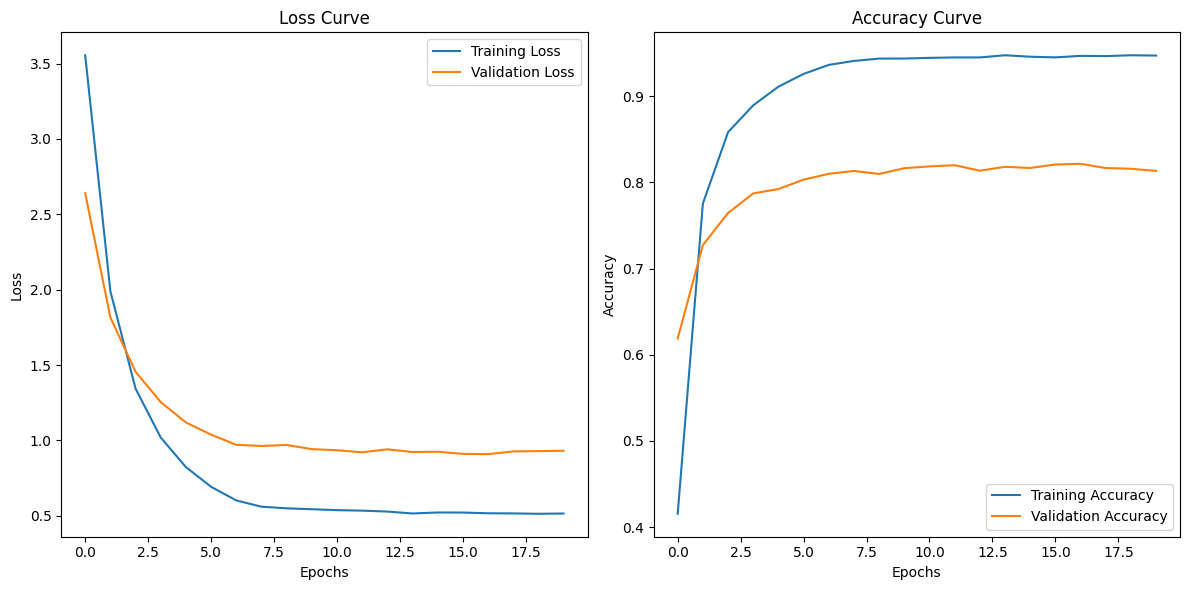


Training time: 1149.90 seconds


In [20]:
import numpy as np
import torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss, test_accuracy = 0.0, 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)
    
    test_loss /= len(test_loader)
    test_accuracy = correct_preds.double() / total_preds
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

def make_predictions(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)


def plot_training_history(train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(12, 6))

    # loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

y_true, y_pred = make_predictions(model, test_loader)

accuracy_per_class = calculate_per_class_accuracy(y_true, y_pred, num_classes)

report = generate_classification_report_csv(y_true, y_pred, num_classes, filename='fruits_classification_report_resnet.csv')

macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy = calculate_macro_weighted_averages(report, accuracy_per_class, y_true, num_classes=num_classes)

plot_training_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

print(f"\nTraining time: {training_time:.2f} seconds")
